# **Focus** : How to simplify the shape of a line/polygon ? 
## Detailed explaination of some generalization algorithms
Press **`space bar`** to display the next slide.
_If this Notebook doesn't appear in slideshow mode, reload the page_

- 🙋 **For whom ?** : 
  - people who have spatial data represented by lines or polygones and wish to simplify its aspect.
  - expert cartographers wishing to discover new simplification algorithms offered by the CartAGen tool
  - student in algorithm class 

Press **`spacebar`** and **`scroll down`** to display the following message. _Reload the page if you can't scroll down._ 


- ❓ **What is CartAGen ?** :
    - an **open source Python library** made by **IGN** (i.e the french national mapping agency) researchers
    - a tool to carry out cartographic generalization processes and **automate** them
    - a **QGIS plugin** to use the Python library in a GIS environment  
    
Press **`space bar`** and **`scroll down`** to show next message 


- 📗 **How to use this Notebook ?** : 
    - a Notebook is a document that mixes **markdown cells** (i.e. cells with formatted text like this one) and **code cells**, which you can modify and execute at will

Press **`right arrow`** to show next slide and start part 0, or press **`space bar`** to show sub-slide and see useful links

   
- 🔗 **Useful links** : 
    - [Library repository](https://github.com/LostInZoom/cartagen4py?tab=readme-ov-file) 
    - [QGIS Plugin repository](https://github.com/LostInZoom/cartagen-qgis)
    - [CartAGen documentation](https://cartagen.readthedocs.io/en/latest/)

_by Paul Bourcier, 2024 - EUPL 1.2_

Press **`space bar`** to show next slide, press **`shift + space bar`** to go backward\
**`Click`** question mark icon to show other shortcuts

## ⚙️ **Part 0 :** Preparing the working environment

Press **`space bar`** to show code cell, then press **`shift + enter`** to execute it\
**`*`** symbol means code output is loading

In [1]:
# Importing libraries

import cartagen as cg # the main library, containing cartographic generalization algorithms

#geographic data manipulation 
import geopandas as gp # used to import and manipulate geographic data
from shapely.geometry import Polygon, MultiPolygon, Point, LineString # Create and manipulate geometries
from shapely.ops import linemerge, transform
from time import sleep # Creating loading bar

#displaying the data
from matplotlib import pyplot as plt # for ploting results, especially maps
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # adding scalebar to the maps
import matplotlib.colors as matcol # generating color palettes
from matplotlib.path import Path  # Plot generation
from matplotlib.patches import PathPatch # Plot generation
from mpl_toolkits.axisartist.axislines import Subplot # Plot generation
import matplotlib.colors as mcolors #generating colors 
import matplotlib.cm as cm #used to display colorbar
import contextily as ctx # Adding basemaps

#creating interactive outputs
import ipywidgets # creation of interactive plots
from IPython.display import display, clear_output
import pydeck as pdk #deck.gl in Python for interactive maps
import json #manipulating dictionnaries
import progressbar
import ipyleaflet #creates interactive maps
from time import sleep

# other data manipulation
import pandas as pd # used to concatenate datas
import numpy as np # Using mathematical operations in Python
from sklearn import cluster #clustering methods

import random #generating random numbers
import warnings # Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*GeoDataFrame you are attempting to plot is empty.*") # Remove user warning 
warnings.filterwarnings("ignore", category=UserWarning, message=".*CRS not set for some of the concatenation inputs.*.")

**Cartogaphic generalisation** refers to the processes of transforming the graphical representation of the elements of a map to lower its complexity.

Here are some examples of generalisation techniques : 


![Alt text](https://raw.githubusercontent.com/gowestmen/images/refs/heads/main/carto_generalization_operators.png)

The need for cartographic generalisation can occurs in different situations : 
- When the map is unreadable because there are too much element on it/the elements are too small
- In the context of sensible spatial data (ex : adresses of hospital patients), to prevent from be able to identify precise locations
- For aestetic purposes
- To reduce the complexity/weight of spatial data prior to other geoprocessings

When it comes to vector data taking the form of line or polyon, that can represent feature like roads, river, administrative boundaries, etc., cartographic generalisation often consists in geometry simplification.

In **CartAGen**, there are curently four available algorithms dedicated to those techniques. Each of these algorithms have their own specifities, making them more or less suitable depending on the feature represented. Some are specialized in generalizing river, meanwhile some other seems more adapted to roads.   

To choose wisely which of these algorithms best suits your datas, it is important to understand how they works ! This Notebook is meant to show you this.
Here are the algorithms reviewed : 
- Douglas-Peucker algorithm
- Visvalingam-Whyatt algorithm
- Raposo algorithm
- Li-Openshaw algorithm 

##  **Part 1** : Douglas-Peucker algorithm

This line simplification algorithm created by David H. Douglas and Thomas K. Peucker. It is the oldest of the four presented here.

It is a line filtering algorithm, which means that it filters the vertices of the line (or polygon) to only retain the most important ones to preserve the shape of the line. The algorithm iteratively searches the most characteristics vertices of portions of the line and decides to retain or remove them given a distance threshold.

**1.1/** Load the line to simplify

In [2]:
line_1 = gp.read_file("data/data_lines/ligne.geojson")
line_1_vertices = gp.GeoDataFrame(geometry=gp.GeoSeries([Point(vertice) for vertice in line_1.geometry[0].coords]))
load_vertices = ipywidgets.Checkbox(
    value=False,
    description='Show vertices'
)
figure_size = ipywidgets.IntSlider(value =6, min = 1, max = 16,step = 1,continuous_update=False)

def load_line_1(figure_size, load_vertices):
    ax = line_1.plot(figsize=(figure_size,figure_size))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if load_vertices == True:  
        line_1_vertices.plot(ax=ax)

out_load_line_1 = ipywidgets.interactive(load_line_1, figure_size = figure_size, load_vertices = load_vertices)
display(out_load_line_1)

interactive(children=(IntSlider(value=6, continuous_update=False, description='figure_size', max=16, min=1), C…

**1.2/** Principle

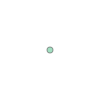

In [30]:
pt_green[(pt_green['distance'] == max(pt_green['distance']))].geometry[pt_green[(pt_green['distance'] == max(pt_green['distance']))].geometry.index[0]]

In [32]:
next_step = ipywidgets.Button(description='Next step',button_style='')
back_step = ipywidgets.Button(description='Previous step',button_style='')
count = ipywidgets.IntText(value=0,disabled=True)

def dp(step):
    global pt_red
    global pt_green
    if count.value == 0:
        ax = line_1.plot(color="grey")
        line_1_vertices.plot(ax=ax,color="grey")
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    if count.value == 1:
        ax = line_1.plot(color="grey")
        line_1_vertices.plot(ax=ax,color="grey")
        gp.GeoDataFrame(geometry=gp.GeoSeries(LineString([line_1_vertices.geometry[0],line_1_vertices.geometry[25]]))).plot(ax=ax)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        print("Retrieving the line formed by the first and last point")
    if count.value == 2:
        print("The points below a certain distance are removed")
        ax = line_1.plot(color="grey")
        buff = gp.GeoSeries(LineString([line_1_vertices.geometry[0],line_1_vertices.geometry[25]])).buffer(15,cap_style='flat')
        buff.plot(ax=ax,color = "orange", alpha = 0.5)
        gp.GeoDataFrame(geometry=gp.GeoSeries(LineString([line_1_vertices.geometry[0],line_1_vertices.geometry[25]]))).plot(ax=ax)
        pt_red = []
        pt_green = []
        for i in range(len(line_1_vertices)):
            pt = line_1_vertices[(line_1_vertices.index == i)].geometry
            pt = pt.reset_index(drop=True)
            
            if pt.intersects(buff.geometry)[0] and i != 0 and i != 25:
                pt.plot(ax=ax,color = "red")
                pt_red.append(pt)
            else: 
                pt.plot(ax=ax,color = "green")
                pt_green.append(pt)
        pt_red = gp.GeoDataFrame(geometry = gp.GeoSeries([point[0] for point in pt_red]))
        pt_green = gp.GeoDataFrame(geometry = gp.GeoSeries([point[0] for point in pt_green]))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    if count.value == 3:
        print("As there are still green points, we compute two new lines with the perpendicullarly farthest point from the previous line")
        ax = line_1.plot(color="grey")
        first_line = gp.GeoDataFrame(geometry=gp.GeoSeries(LineString([line_1_vertices.geometry[0],line_1_vertices.geometry[25]])))
        first_line.plot(ax=ax)
        pt_red.plot(ax=ax, color='red',alpha = 0.5)
        pt_green.plot(ax=ax, color='green')
    
        pt_green['distance'] = pt_green.geometry.apply(lambda point: point.distance(first_line.geometry[0]))
        second_line_1 = gp.GeoDataFrame(geometry=gp.GeoSeries(LineString([line_1_vertices.geometry[0],pt_green[(pt_green['distance'] == max(pt_green['distance']))].geometry[pt_green[(pt_green['distance'] == max(pt_green['distance']))].geometry.index[0]]])))
        second_line_2 = gp.GeoDataFrame(geometry=gp.GeoSeries(LineString([pt_green[(pt_green['distance'] == max(pt_green['distance']))].geometry[pt_green[(pt_green['distance'] == max(pt_green['distance']))].geometry.index[0]],line_1_vertices.geometry[25]])))
        second_line_1.plot(ax=ax)
        second_line_2.plot(ax=ax)

        perpen_line = gp.GeoDataFrame(geometry=gp.GeoSeries(LineString([second_line_1.geometry[0],
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

def next(next_step):
    count.value+=1
        
next_step.on_click(next)

def back(back_step):
    count.value-=1
        
back_step.on_click(back)

out_dp = ipywidgets.interactive(dp,step=count)
display(next_step, back_step, out_dp)

Button(description='Next step', style=ButtonStyle())

Button(description='Previous step', style=ButtonStyle())

interactive(children=(IntText(value=0, description='step', disabled=True), Output()), _dom_classes=('widget-in…

In [ ]:
for i in range(len(com)):
    com_simp.append(cg.douglas_peucker(list(com.geometry)[i], 200,False))
gp.GeoDataFrame(geometry = com_simp).plot()